# Previsão de temperatura média por mês em Curitiba

In [1]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from scipy import stats

Dataset: https://www.kaggle.com/volpatto/temperature-timeseries-for-some-brazilian-cities

## Preparando os dados

In [2]:
arquivo = 'https://raw.githubusercontent.com/jhklarcher/data-science/master/datasets/station_curitiba.csv' # Nome e local do arquivo
df = pd.read_csv(arquivo)

In [3]:
df.shape

(59, 18)

As temperaturas são registradas por mês nas colunas e ano nas linhas.

In [4]:
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1961,21.80,21.84,20.51,19.14,16.05,14.87,15.43,17.17,18.56,19.53,20.56,20.81,21.52,18.57,15.82,19.55,18.86
1,1962,20.47,20.29,20.78,17.42,14.49,12.19,12.29,14.85,16.46,15.48,19.07,20.01,20.52,17.56,13.11,17.00,17.05
2,1963,22.57,21.41,22.06,18.82,15.71,13.76,15.62,16.20,19.65,18.50,20.37,19.79,21.33,18.86,15.19,19.51,18.72
3,1964,21.33,21.57,20.29,19.26,15.46,13.03,12.08,14.97,16.93,17.28,17.76,19.47,20.90,18.34,13.36,17.32,17.48
4,1965,20.31,21.99,19.11,18.61,15.12,16.17,13.94,16.55,17.66,18.23,19.84,20.92,20.59,17.61,15.55,18.58,18.08


Removendo as ultimas colunas (temperatura por trimestre).

In [5]:
df = df.iloc[:, :-5]

Deixando a temperatura por mes em formato de coluna. Em seguida transformando os dados para o formato que o Prophet utiliza.

In [6]:
df = pd.melt(df, id_vars=['YEAR'])

In [7]:
df.head()

,YEAR,variable,value
0,1961,JAN,21.80
1,1962,JAN,20.47
2,1963,JAN,22.57
3,1964,JAN,21.33
4,1965,JAN,20.31


In [8]:
df['date'] = df['YEAR'].astype(str)+'/'+ df['variable']

In [9]:
df.head()

,YEAR,variable,value,date
0,1961,JAN,21.80,1961/JAN
1,1962,JAN,20.47,1962/JAN
2,1963,JAN,22.57,1963/JAN
3,1964,JAN,21.33,1964/JAN
4,1965,JAN,20.31,1965/JAN


In [10]:
df = df.drop(['YEAR', 'variable'], axis=1)

In [11]:
df['date'] = pd.to_datetime(df['date'])
df.columns = ['y', 'ds']

In [12]:
df = (df.sort_values('ds')).reset_index(drop=True)

In [13]:
df.head()

,y,ds
0,21.80,1961-01-01
1,21.84,1961-02-01
2,20.51,1961-03-01
3,19.14,1961-04-01
4,16.05,1961-05-01


Observando os dados

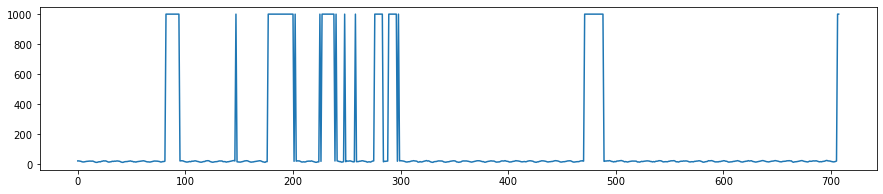

In [14]:
plt.rcParams["figure.figsize"] = (15,3)
plt.plot(df['y'])

Removendo outliers.

In [15]:
df = df[df['y']<500]

Agora sem os outliers

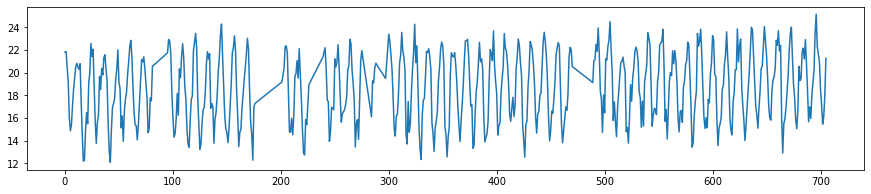

In [16]:
plt.rcParams["figure.figsize"] = (15,3)
plt.plot(df['y'])

## Modelo

In [17]:
df_test = df.iloc[-12:, :]
df_train = df.iloc[:-12, :]

In [18]:
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
preds = m.predict(df_test)

## Calculando o erro médio absoluto das previsões

In [20]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(preds['yhat'], df_test['y'])

1.1073973318076356

O erro é de aproximadamente 1°C

## Visualizando os valores previstos pelo modelo

Componentes do modelo

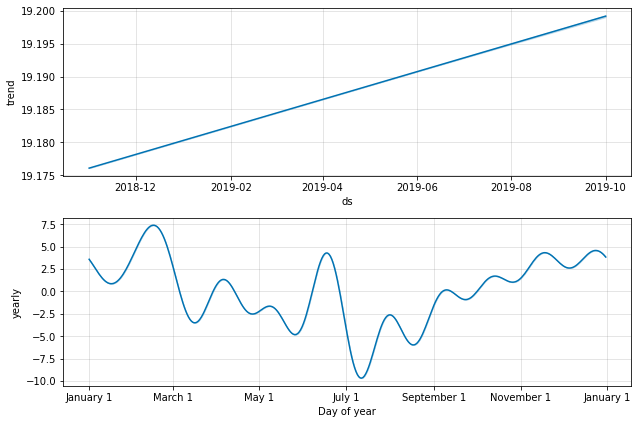

In [21]:
p2 = m.plot_components(preds)

Diferença entre previsto e modelo.

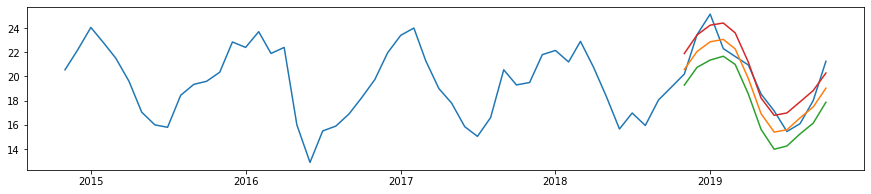

In [22]:
plt.rcParams["figure.figsize"] = (15, 3)

plt.plot(df.tail(60)['ds'], df.tail(60)['y'])
plt.plot(df_test['ds'], preds['yhat'])
plt.plot(df_test['ds'], preds['yhat_lower'])
plt.plot(df_test['ds'], preds['yhat_upper'])

Previsão para o ano seguinte

In [23]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
future = []
for i in range(11,13):
    future.append('2019-{:02d}-01'.format(i))
for i in range(1,11):
    future.append('2020-{:02d}-01'.format(i))

In [25]:
future = pd.Series(future, name="ds")

In [26]:
future = pd.DataFrame(pd.to_datetime(future, format='%Y-%m-%d'))

In [27]:
future

,ds
0,2019-11-01
1,2019-12-01
2,2020-01-01
3,2020-02-01
4,2020-03-01
5,2020-04-01
6,2020-05-01
7,2020-06-01
8,2020-07-01
9,2020-08-01


In [28]:
df.tail()

,y,ds
701,17.15,2019-06-01
702,15.45,2019-07-01
703,16.10,2019-08-01
704,18.00,2019-09-01
705,21.25,2019-10-01


In [29]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-11-01,20.733266,19.377508,22.139361
1,2019-12-01,22.343606,20.939751,23.646316
2,2020-01-01,23.201837,21.905783,24.517909
3,2020-02-01,23.156544,21.783922,24.507236
4,2020-03-01,22.077880,20.678720,23.434422


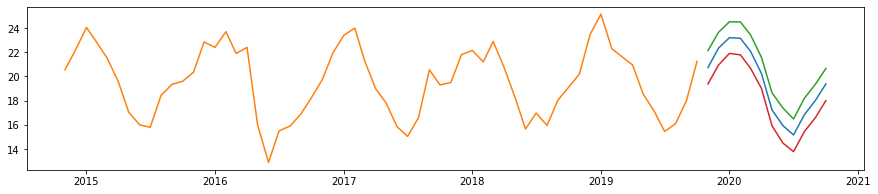

In [30]:
plt.plot(forecast['ds'], forecast['yhat'])
plt.plot(df.tail(60)['ds'], df.tail(60)['y'])
plt.plot(forecast['ds'], forecast['yhat_upper'])
plt.plot(forecast['ds'], forecast['yhat_lower'])

